## Import Library
First, let's download and install dependencies, and import the relevant packages.

In [80]:
import tensorflow as tf 

### Running this script using GPU is recommended

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter
import random
import matplotlib.pyplot as plt #library for visualiation
from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K
from keras.models import load_model

import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

# Listing current data on our folder.
import os
print(os.listdir("."))

['__notebook_source__.ipynb']


`music21` is a Toolkit for Computer-Aided Musicology and Symbolic Music Data. It was developed at MIT. 
We will use this for understaning our music.

In [81]:
pip install music21

Note: you may need to restart the kernel to use updated packages.


## Loading the dataset

MIDI is a standard format for storing music files. MIDI stands for Musical Instrument Digital Interface. MIDI files contain the instructions rather than the actual audio. Hence, it occupies very little memory. That’s why it is usually preferred while transferring files.

In [82]:
#library for understanding music
from music21 import *
def read_midi(file):
    
    print("Loading Music File:",file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    midi = converter.parse(file)
  
    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
   
    for part in s2.parts:
        #select elements of only piano
        print(str(part))
        if 'Piano' in str(part): 

            notes_to_parse = part.recurse() 

            #finding whether a particular element is note or a chord
            for element in notes_to_parse:

                #note
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))

                #chord
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

In [83]:
#specify the path
#path='../input/maestropianomidi/maestro-v3.0.0/2018/'
path = '../input/anime-music-midi/data/undertale/'

#read all the filenames
files=[i for i in os.listdir(path) if i.endswith(".mid")]

#reading each midi file
notes_array = np.array([read_midi(path+i) for i in files])

Loading Music File: ../input/anime-music-midi/data/undertale/Undertale - Fallen Down.mid
<music21.stream.Part Piano>
Loading Music File: ../input/anime-music-midi/data/undertale/Undertale - Its Raining Somewhere Else.mid
<music21.stream.Part Piano>
Loading Music File: ../input/anime-music-midi/data/undertale/Undertale - sans.mid
<music21.stream.Part Piano>
Loading Music File: ../input/anime-music-midi/data/undertale/Undertale - Dogsong.mid
<music21.stream.Part Piano>
Loading Music File: ../input/anime-music-midi/data/undertale/Undertale - Megalovania.mid
<music21.stream.Part Piano>
Loading Music File: ../input/anime-music-midi/data/undertale/Undertale - ASGORE.mid
<music21.stream.Part Piano>
Loading Music File: ../input/anime-music-midi/data/undertale/Undertale - Snore Symphony.mid
<music21.stream.Part Piano>
Loading Music File: ../input/anime-music-midi/data/undertale/Undertale - Menu Full.mid
<music21.stream.Part Piano>
Loading Music File: ../input/anime-music-midi/data/undertale/Und

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


## Preprocessing

In [84]:
#converting 2D array into 1D array
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
print(len(unique_notes))

448


In [85]:
#computing frequency of each note
freq = dict(Counter(notes_))

In [86]:
frequent_notes = [note_ for note_, count in freq.items() if count>=50]
print(len(frequent_notes))
print(frequent_notes)

181
['2.6', '1.6', '6.9', '11', '3.9', 'C#5', 'F#4', 'E-4', '11.3', '11.4', '3', '4.6', '3.6', '6.7', '10', 'G5', 'D4', 'B-3', '4.9', '6', 'E5', 'C#4', 'E4', 'D5', 'A4', '1', '9.2', '9.1', 'A3', 'B3', 'F#3', 'E-3', '6.11', '7.11', '2', 'G3', '2.7', '6.10', '10.2', 'G4', '9.1.4', 'E3', '7.11.2', 'E-5', 'C5', 'B-5', 'B-4', 'F5', 'F4', 'G#4', '3.7', '5.8', '10.3', '7.0', 'C3', 'G2', 'C2', '0.5', '7', 'D2', 'G1', 'E-2', 'B-2', 'F2', 'B-1', '5.10', '0', 'F1', '2.3', '5.7', '0.3.7', 'G#1', 'F#2', 'G#2', '8.11.3', '3.8', '8.1', 'B2', 'F#1', 'C#2', '6.8.1', '1.5.8', 'C#3', '8.0', '7.8.1', '1.3', 'B1', 'E2', '4.8.11', '3.7.10', '1.4.8', 'D3', '7.10', 'G#3', '10.1', '0.3', 'C4', 'F3', '10.0.3', '0.3.6', '2.5', '0.2', '11.2', '2.8', '9.0', '0.2.5', '9.11', '8.11', '5.11', '11.2.5', '8', 'G#5', 'D6', 'C6', '2.5.9', 'A5', '5.9.0', '10.2.5', '0.4', '4.5.10', '5.8.10', '4.7.10', '7.8', '4.7', '5.9', '7.9', '4.10', 'A2', 'A1', '9', '2.4', '4', '0.4.7', '4.5', '5', '1.7', '3.4', 'E-6', '3.5', 'B5', '1.

In [87]:
new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)            
    new_music.append(temp)
    
new_music = np.array(new_music)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


In [88]:
no_of_timesteps = 32
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_ ) - no_of_timesteps, 1):
        
        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps ]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)

        
        
x=np.array(x)
y=np.array(y)

print(x)
print(y)

[['2.6' '1.6' '6.9' ... '2.6' '11' '6.7']
 ['1.6' '6.9' '1.6' ... '11' '6.7' '10']
 ['6.9' '1.6' '6.9' ... '6.7' '10' '2.6']
 ...
 ['F5' 'E-4' 'E-3' ... 'F3' 'G#4' 'F#3']
 ['E-4' 'E-3' 'E-2' ... 'G#4' 'F#3' 'E-4']
 ['E-3' 'E-2' 'B-4' ... 'F#3' 'E-4' 'G#3']]
['10' '2.6' '10' ... 'E-4' 'G#3' 'E-4']


In [89]:
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

In [90]:
#preparing input sequences
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)

In [91]:
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])

In [92]:
#train test split
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)

print(len(x_tr))
print(len(x_val))

42476
10620


We have generated a 'music_wavenet.mid' file which is an is a piano tune generated using wavenet on the dataset.

## Defining Model Using LSTM

First, we will use the wavenet architecture for generation.

In [93]:
K.clear_session()
model2 = Sequential()
#embedding layer
model2.add(Embedding(len(unique_x), 100, input_length=32,trainable=True)) 
model2.add(LSTM(128,return_sequences=True))
model2.add(Dropout(0.3))
model2.add(LSTM(128))
model2.add(Dense(256))
model2.add(Dropout(0.3))
model2.add(Activation('relu'))
model2.add(Dense(len(unique_x)))
model2.add(Dropout(0.3))
model2.add(Activation('softmax'))
model2.build(32)
model2.summary()
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

mc2=ModelCheckpoint('lstm_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)

history = model2.fit(np.array(x_tr),np.array(y_tr),batch_size=128,epochs=100, validation_data=(np.array(x_val),np.array(y_val)),verbose=1, callbacks=[mc2])



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           18100     
_________________________________________________________________
lstm (LSTM)                  (None, 32, 128)           117248    
_________________________________________________________________
dropout (Dropout)            (None, 32, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
activation (Activation)      (None, 256)               0

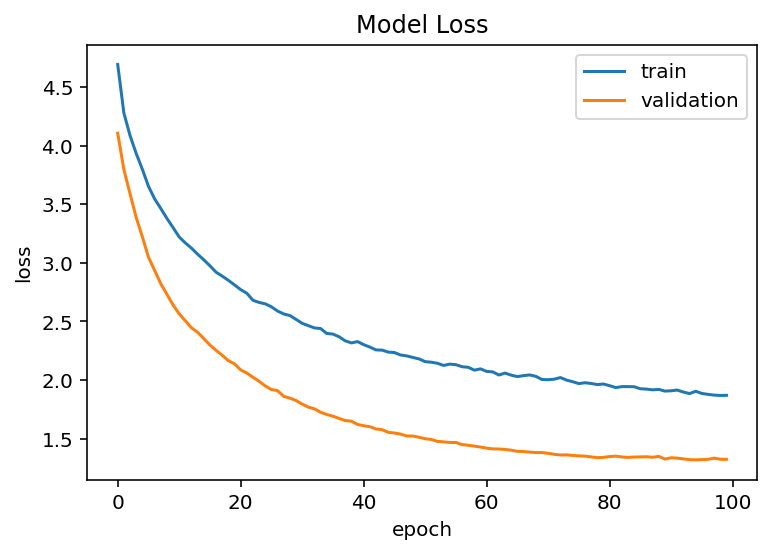

In [94]:
import keras.backend as K


def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots()
    # first plot
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title('Model Loss')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)


## Make predictions

In [95]:
ind = np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions=[]
for i in range(20):

    random_music = random_music.reshape(1,no_of_timesteps)

    prob  = model2.predict(random_music)[0]
    y_pred= np.argmax(prob,axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]
    
print(predictions)

[92, 3, 81, 116, 165, 67, 62, 165, 116, 138, 67, 62, 138, 116, 138, 67, 62, 138, 67, 62]


In [96]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x)) 
predicted_notes = [x_int_to_note[i] for i in predictions]

## Converting back to MIDI

In [97]:
def convert_to_midi(prediction_output):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='music_wavenet.mid')

In [98]:
convert_to_midi(predicted_notes)